## Data Collection and Feature Engineering steps

In [5]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def filter_top_emotions(data, top_n=2):
    emotion_counts = data['emotion'].value_counts()
    top_emotions = emotion_counts.head(top_n).index
    label_mapping = {label: new_label for new_label, label in enumerate(top_emotions)}
    filtered_data = data[data['emotion'].isin(top_emotions)].copy()
    filtered_data.loc[:, 'emotion'] = filtered_data['emotion'].map(label_mapping)
    return filtered_data, label_mapping

def sample_data(data, fraction=0.1):
    return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URLs for train and validation data
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
sampled_train_data, label_mapping = filter_top_emotions(train_data)
sampled_train_data = sample_data(sampled_train_data)

# Process validation data
validation_data = load_data(validation_data_url)
validation_data = preprocess_data(validation_data)
sampled_validation_data, _ = filter_top_emotions(validation_data, top_n=len(label_mapping))
sampled_validation_data = sample_data(sampled_validation_data)

# Tokenize the comments
train_tokenized_comments = tokenize_data(sampled_train_data['comment'].to_list())
validation_tokenized_comments = tokenize_data(sampled_validation_data['comment'].to_list())

# Prepare training data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
y_train = torch.tensor(sampled_train_data['emotion'].values)

# Prepare validation data
X_validation = validation_tokenized_comments['input_ids']
attention_masks_validation = validation_tokenized_comments['attention_mask']
y_validation = torch.tensor(sampled_validation_data['emotion'].values)

# Map the new labels to their original emotion names
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}
top_emotions_dict = {label_mapping[k]: emotions_dict[k] for k in label_mapping}

print()
print("Top 2 most common emotions:", [top_emotions_dict[e] for e in sorted(top_emotions_dict)])
print("Sampled train data shape:", sampled_train_data.shape)
print("Sampled validation data shape:", sampled_validation_data.shape)

/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_16146/1362815814.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_16146/1362815814.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_ke


Top 2 most common emotions: ['neutral', 'admiration']
Sampled train data shape: (1553, 2)
Sampled validation data shape: (192, 2)


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

### Initialization

In [23]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def print_device_info(device):
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    elif device.type == "mps":
        torch.mps.empty_cache()
        print(f"MPS memory allocated: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
    elif device.type == "cpu":
        print("No GPU available. Using CPU.")
              
device = get_device()
print_device_info(device)

Using device: mps
MPS memory allocated: 0.00 GB


### Define the model

In [7]:
from transformers import BertForSequenceClassification
# Load the BERT model
# we will use the bert-base-uncased model
# this model will classify the comments into 10 emotions

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device);  # Move the model to the GPU

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the emotion dataset

In [22]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["ACCELERATE_USE_MPS_DEVICE"] = "True"


from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments


# Create a Dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Prepare datasets
train_dataset = EmotionDataset(X_train, attention_masks_train, y_train)
validation_dataset = EmotionDataset(X_validation, attention_masks_validation, y_validation)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",  # Evaluate every few steps
    eval_steps=10,  # Evaluate every 10 logging steps
    no_cuda=True if device != 'cuda' else False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Train the model
trainer.train()

  0%|          | 0/294 [00:00<?, ?it/s]

KeyboardInterrupt: 

{'eval_loss': 0.960740327835083, 'eval_runtime': 1.798, 'eval_samples_per_second': 106.788, 'eval_steps_per_second': 6.674, 'epoch': 0.10204081632653061, 'step': 10}
{'eval_loss': 0.8378753066062927, 'eval_runtime': 1.8162, 'eval_samples_per_second': 105.718, 'eval_steps_per_second': 6.607, 'epoch': 0.20408163265306123, 'step': 20}
{'eval_loss': 0.6794535517692566, 'eval_runtime': 1.7988, 'eval_samples_per_second': 106.737, 'eval_steps_per_second': 6.671, 'epoch': 0.30612244897959184, 'step': 30}
{'eval_loss': 0.5730319619178772, 'eval_runtime': 1.8407, 'eval_samples_per_second': 104.311, 'eval_steps_per_second': 6.519, 'epoch': 0.40816326530612246, 'step': 40}
{'eval_loss': 0.5262773633003235, 'eval_runtime': 1.8506, 'eval_samples_per_second': 103.752, 'eval_steps_per_second': 6.484, 'epoch': 0.5102040816326531, 'step': 50}
{'eval_loss': 0.492962121963501, 'eval_runtime': 1.8648, 'eval_samples_per_second': 102.962, 'eval_steps_per_second': 6.435, 'epoch': 0.6122448979591837, 'step': 6

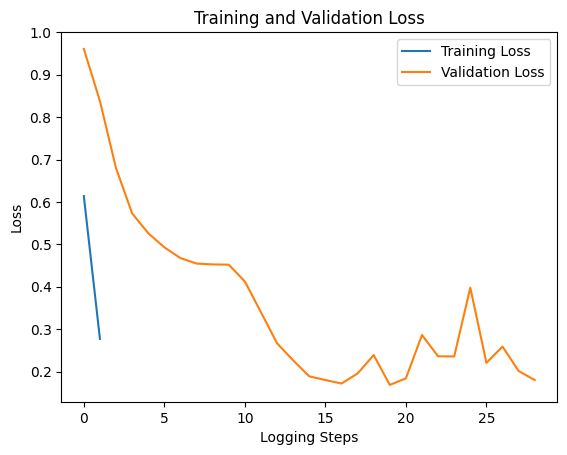

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the logs
train_losses = []
eval_losses = []
for log in trainer.state.log_history:
    print(log)
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()